# Individual parcellation pipeline

This jupyter notebook is to demenstrate a minimal example for generating individual cerebellar parcellations using individual localizing data. Usually, the individual data are collected within a relatively short period (e.g. 10 mins) or higher signal-to-noise ratio. If we generate individual parcellations based on those data directly using some traditional methods, the results are poor and very noisy. However, in the `HierarchBayesParcel` framework, the high-quality individual parcellations are generated using a common group prior and individual localizing data. The main idea of this settings is to "fill-in" the knowledge to those uncertain areas with the group prior. This is a unique advantage that Bayesian model can offer.

To successfully implement this pipeline, some dependent packages are required (see below imports), including [HierarchBayesParcel](https://github.com/DiedrichsenLab/HierarchBayesParcel/tree/main), [Functional_Fusion](https://github.com/DiedrichsenLab/Functional_Fusion), and [nitools](https://github.com/DiedrichsenLab/nitools) repository. See the READ.me in those repos for installation details.
<br>

## Import all dependencies

In [1]:
# Add the directories of necessary packages to the Python path
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.full_model as fm
from FusionModel.util import plot_data_flat

pt.set_default_tensor_type(pt.cuda.FloatTensor
                           if pt.cuda.is_available() else
                           pt.FloatTensor)

## Step 1: Define the the space in which to generate the individual parcellations

This step defines the atlas space (e.g. "fs32k", "SUIT", "MNISymC3", etc) - an atlas in Functional_Fusion defines a specific set of brainlocations (grayordinates) that are being sampled. Both the probabilistic atlas and the data need to be read into this space. 

In [2]:
atlas, _ = am.get_atlas('MNISymC3')

## Step 2a: Load the probabilistic group atlas from a _probseg.nii file

Now we read the probabilistic group atlas from a _probseg.nii file. 

In [4]:
atlas_dir = 'Y:/data/FunctionalFusion/Atlases/tpl-MNI152NLin2009cSymC'
model_name = f'/atl-Anatom_space-MNI152NLin2009cSymC_probseg.nii'
U = atlas.read_data(atlas_dir + model_name)
U = U.T

## Step 2b: Load the probabilistic group atlas from a pre-trained model
Alternatively, we can also load the probabilistic group atlas from a pre-trained model. See our [model paper](https://www.biorxiv.org/content/10.1101/2023.05.24.542121v1) for more details.

In [3]:
model_dir = 'Y:/data/Cerebellum/ProbabilisticParcellationModel/Models'
model_name = f'/Models_03/asym_Md_space-MNISymC3_K-17'
fname = model_dir + model_name
U, _ = ar.load_group_parcellation(fname, device='cuda')

## Step 3: Build an arrangement model

By using `HierarchBayesParcel` computational framework, the parcellations are estimated by training a "full_model" class consists of a common arrangement model and one or more emission models (See this [paper](https://www.biorxiv.org/content/10.1101/2023.05.24.542121v1.abstract) for more details). To build the common arrangement model `ar_model`, user needs to attach a group prior (in log-space) with the desired arrangement model type.

Note, a `prior_type` must be given to specify the type of the input `U`. prior_type=`prob` indicates the input `U` is marginal probability matrix where columns are sum to 1 (mostly load from a probseg.nii file); prior_type=`logpi` means the input `U` is already the prior in log-space, usually this `U` comes from a pre-trained model.

In [4]:
# TODO: If atlas not absolutely necessary, make optional
ar_model = ar.build_arrangement_model(U, prior_type='logpi', atlas=atlas)

## Step 4a: Build custom individual localizing data / info

In this step, we want to load the individual localizing data. As mentioned earlier, the individual localizing data must be in the same `atlas` space which we previously defined. In this step, we showcase an example of how to build the input individual data and associated variables for building the emission models.

In [7]:
# Step 4a.1: Build the data into list of 3d tensor
data_dir = 'Y:/data/FunctionalFusion/MDTB/derivatives/{0}/data'
mdtb_dataset = ds.get_dataset_class('Y:/data/FunctionalFusion','MDTB')
subj = mdtb_dataset.get_participants().participant_id
data, info = [], []
for ses_id in mdtb_dataset.sessions:
    this_data = []
    this_info = []
    info.append(mdtb_dataset.get_info(ses_id=ses_id, type='CondHalf'))
    for i, s in enumerate(subj):
        file_name = f'/{s}_space-{atlas.name}_{ses_id}_CondHalf.dscalar.nii'
        this_data.append(atlas.read_data(data_dir.format(s) + file_name).T)
    data.append(np.stack(this_data))
    
# Step 4a.2: Assemble condition and partition vectors
cond_v, part_v, sub_ind = [], [], []
for j, inf in enumerate(info):
    cond_v.append(inf['cond_num_uni'].values.reshape(-1,))
    part_v.append(inf['half'].values.reshape(-1,))
    sub_ind.append(np.arange(0, len(subj)))

The argument `tdata` is a list of individual localizing data tensor in `atlas` space. Each data tensor has a shape of `num_subj x N x P`, where `num_subj` is the number of subjects, `N` is the number of conditions, and `P` is the number of brain locations. `cond_v` is a list of 1d array to indicate the condition numbers for dimension `N`, and `part_v` is a list of 1d array to specify the partitioning (runs, or repeated measurement for example) of a data tensor. `sub_ind` is to indicate the unique subjects index for each data tensor, repeated subjects across data tensors are theoretically allowed. 

Here, the length of the four outputs should have same length. This length is the number of emission models in your training model. 

## Step 4b: Build individual localizing data / info from Fusion project

If user intends to use the datasets that already included in our [Functional_Fusion](https://github.com/DiedrichsenLab/Functional_Fusion) project, the required individual data/info can be easily built by using our pre-defined functions as below. This is an exclusive way of building the data for the supported datasets. Please find this [paper](https://www.biorxiv.org/content/10.1101/2023.05.24.542121v1) for a list of datasets.

In [6]:
# Step 4b.1: Load the data into 3d tensor
data, info, tds = ds.get_dataset('Y:/data/FunctionalFusion', 'MDTB', atlas=atlas.name, subj=None)

# Step 4b.2: Prepare the data into the right format
tdata, cond_v, part_v, sub_ind = fm.prep_datasets(data, info.sess,
                                                  info['cond_num_uni'].values,
                                                  info['half'].values,
                                                  join_sess=False,
                                                  join_sess_part=False)

## Step 5: Compute the individual parcellations

This step is the main function to generate the individual parcellations, which relies on an established arrangement model `ar_model`, individual training data `tdata`, and necessary information to create the emission models `cond_v`, `part_v`, `sub_ind`.

This function: 

* Builds emissions models for each dataset you pass in 
* Assembles the arrangement and emission models into a full model 
* Trains the emission models on the data (while keeping the arrangement model frozen)
* For each subject, returns the individidual probabilstic parcellation

Note, the function `get_indiv_parcellation` can also learn individual parcellation using a given mean functional response direction `V`. If this is the case, the emission models will freeze the `V` and only estimate concentration parameter `kappa`. Otherwise, please leave `Vs=None`, which means the emission models will be trained from randomly initialized parameters.

In [7]:
indiv_par, _, _ = fm.get_indiv_parcellation(ar_model, tdata, atlas, cond_v, part_v, sub_ind, Vs=None)

D:\python_workspace\HierarchBayesParcel\full_model.py:351: UserWarning: Likelihood decreased - terminating on iteration 15
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')


## Step 6 (Optional): Save the result as gifti/nifti file


In [ ]:
# Convert the individual parcellations to gifti file
K=17
gii_file = nt.make_label_gifti(indiv_par.cpu().numpy().transpose(),
                               labels=["label_{}".format(i) for i in range(K)],
                               column_names=["subj_{}".format(i+1)
                                             for i in range(indiv_par.shape[0])])
nb.save(gii_file, '/Md_Asym_17.dlabel.gii')

## Step 7: Visualization - check your results

This is the last step, where you can plot/check the individual parcellations and make a direct comparison with the group prior.

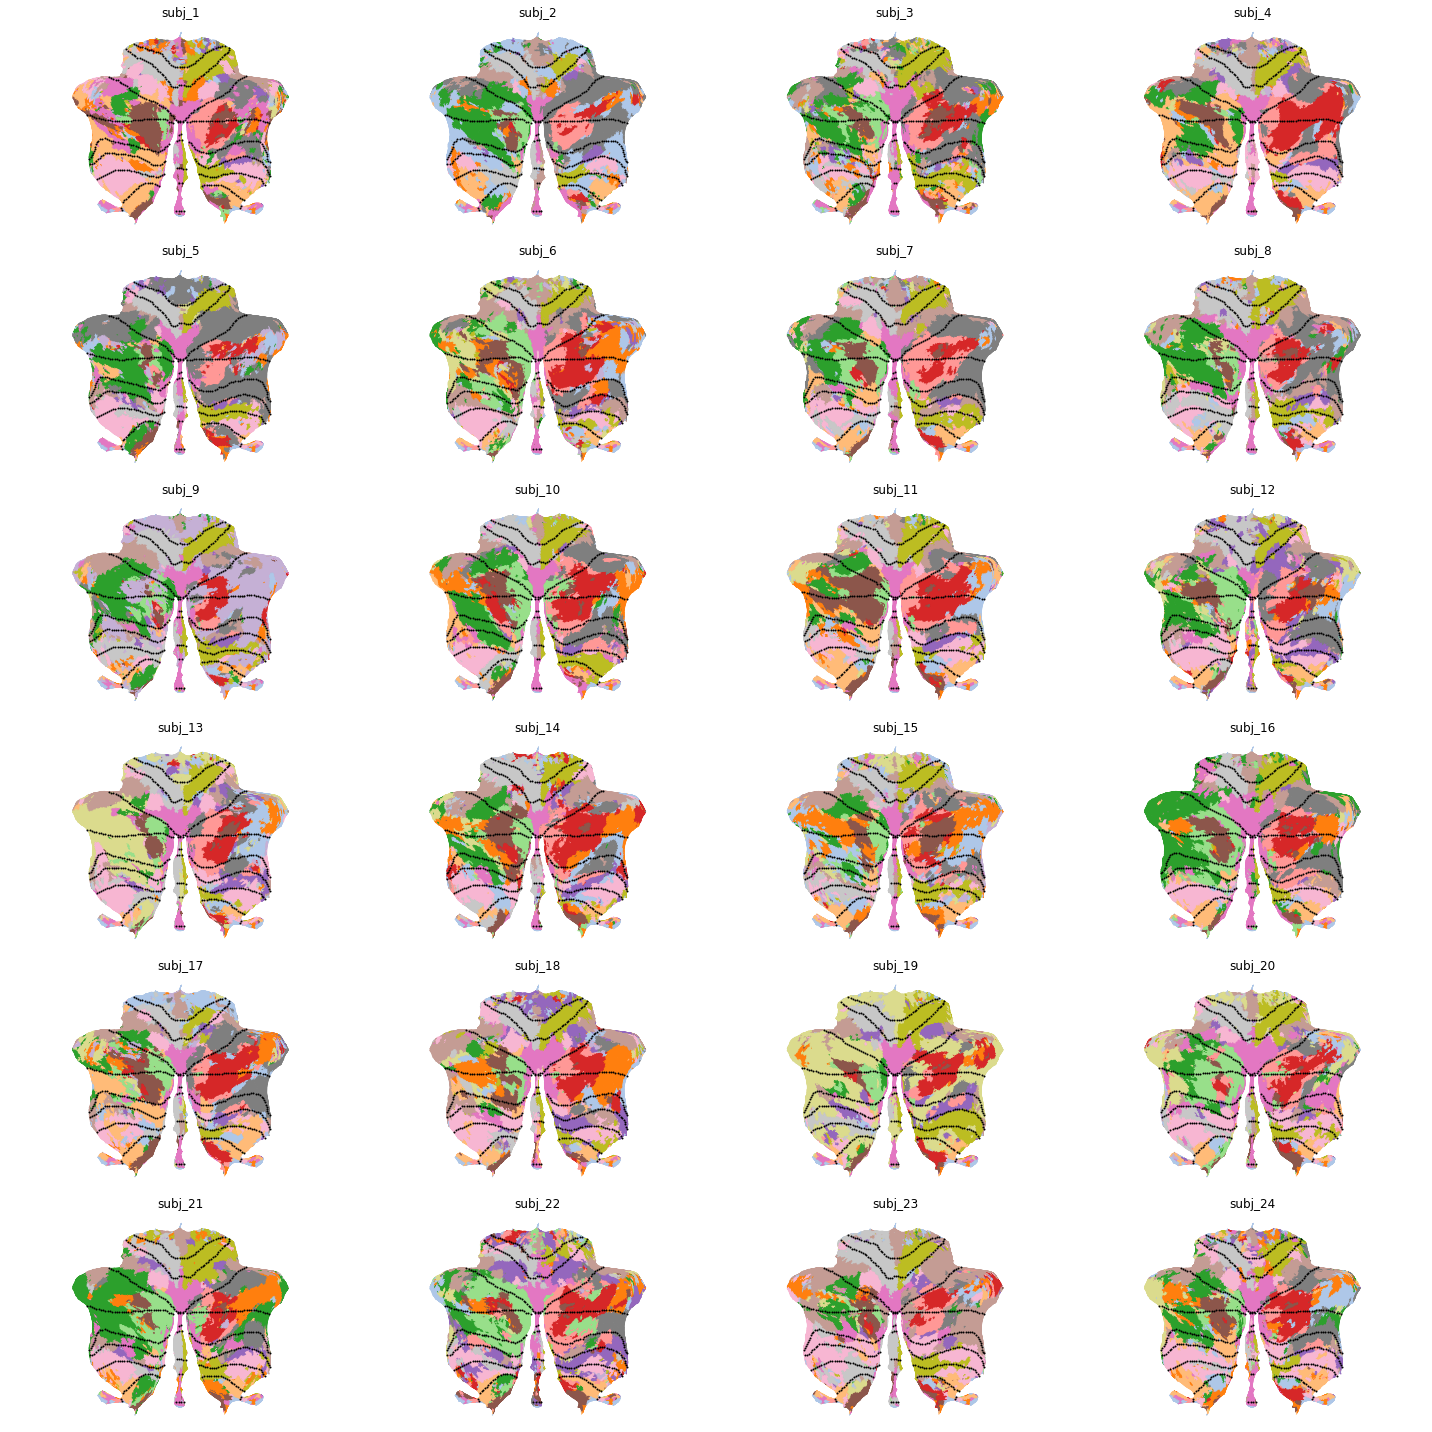

In [11]:
import warnings

# Ignore RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

def plot_multi_flat(data, atlas, grid, cmap='tab20b', dtype='label',
                    cscale=None, titles=None, colorbar=False,
                    save_fig=False):
    """ Plot multiple flatmaps in a grid

    Args:
        data: the input parcellations, shape(N, K, P) where N indicates
              the number of parcellations, K indicates the number of
              parcels, and P is the number of vertices.
        atlas: the atlas name used to plot the flatmap
        grid: the grid shape of the subplots
        cmap: the colormap used to plot the flatmap
        dtype: the data type of the input data, 'label' or 'prob'
        cscale: the color scale used to plot the flatmap
        titles: the titles of the subplots
        colorbar: whether to plot the colorbar
        save_fig: whether to save the figure, default format is png

    Returns:
        The plt figure plot
    """

    if isinstance(data, np.ndarray):
        n_subplots = data.shape[0]
    elif isinstance(data, list):
        n_subplots = len(data)

    if not isinstance(cmap, list):
        cmap = [cmap] * n_subplots

    for i in np.arange(n_subplots):
        plt.subplot(grid[0], grid[1], i + 1)
        plot_data_flat(data[i], atlas,
                       cmap=cmap[i],
                       dtype=dtype,
                       cscale=None,
                       render='matplotlib',
                       colorbar=(i == 0) & colorbar)

        plt.title(titles[i])
        plt.tight_layout()

    if save_fig:
        plt.savefig('/indiv_parcellations.png')

plt.figure(figsize=(20,20))
plot_multi_flat(indiv_par.cpu().numpy(), 'MNISymC3', grid=(6, 4),
                cmap='tab20', dtype='prob',
                titles=["subj_{}".format(i+1) for i in range(indiv_par.shape[0])])

Finally, plot the group prior as a comparison.

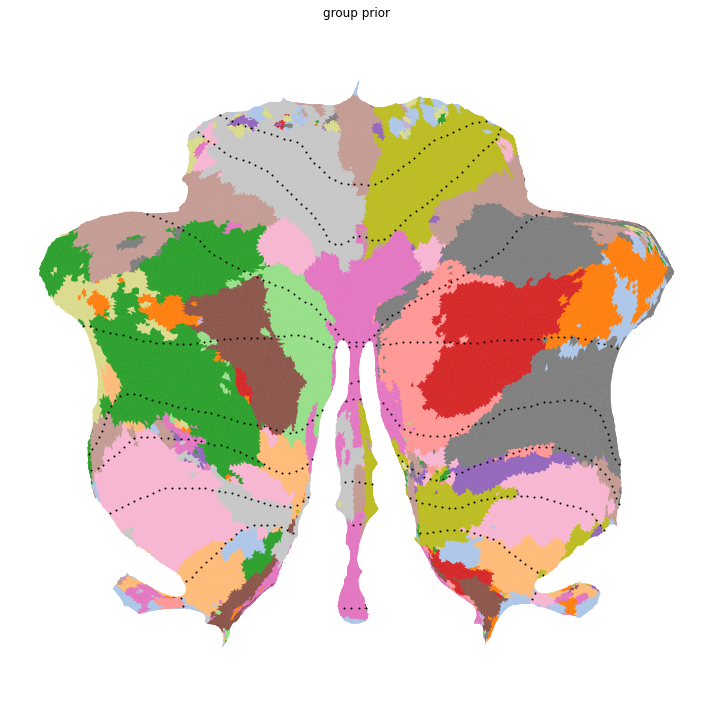

In [14]:
plt.figure(figsize=(10,10))
plot_multi_flat(U.unsqueeze(0).cpu().numpy(), 'MNISymC3', grid=(1, 1),
                cmap='tab20', dtype='prob', titles=['group prior'])